In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, MaxPooling2D
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# establishing path to the directories we use here pathlib to create path, test_dir and train_dir

In [4]:
test_path = "/content/gdrive/MyDrive/CNN Assignment/Test"

In [5]:
train_path="/content/gdrive/MyDrive/CNN Assignment/Train"

In [6]:
import pathlib

In [7]:
train_dir = pathlib.Path(train_path)
test_dir = pathlib.Path(test_path)

In [8]:
# Taking the count of image in test and train directories

In [9]:
train_count = len(list(train_dir.glob('*/*.jpg')))
train_count

2251

In [10]:
test_count=len(list(test_dir.glob('*/*.jpg')))
test_count

118

In [11]:
#Load using keras.preprocessing
#Let's load these images off disk using the helpful image_dataset_from_directory utility.

#Create a dataset
#Define some parameters for the loader:#

#Load using keras.preprocessing
#Let's load these images off disk using the helpful image_dataset_from_directory utility.

#Create a dataset
#Define some parameters for the loader:#

In [12]:
image_rows, image_cols = 180,180
batch_size= 32

we use 80% images from the train dataset to train the model and other 20% to validate the model

In [13]:
# seed set is 123

Arguments

directory: Directory where the data is located. If labels is "inferred", it should contain subdirectories, each containing images for a class. Otherwise, the directory structure is ignored.
labels: Either "inferred" (labels are generated from the directory structure), None (no labels), or a list/tuple of integer labels of the same size as the number of image files found in the directory. Labels should be sorted according to the alphanumeric order of the image file paths (obtained via os.walk(directory) in Python).
label_mode: - 'int': means that the labels are encoded as integers (e.g. for sparse_categorical_crossentropy loss). - 'categorical' means that the labels are encoded as a categorical vector (e.g. for categorical_crossentropy loss). - 'binary' means that the labels (there can be only 2) are encoded as float32 scalars with values 0 or 1 (e.g. for binary_crossentropy). - None (no labels).
class_names: Only valid if "labels" is "inferred". This is the explict list of class names (must match names of subdirectories). Used to control the order of the classes (otherwise alphanumerical order is used).
color_mode: One of "grayscale", "rgb", "rgba". Default: "rgb". Whether the images will be converted to have 1, 3, or 4 channels.
batch_size: Size of the batches of data. Default: 32.
image_size: Size to resize images to after they are read from disk. Defaults to (256, 256). Since the pipeline processes batches of images that must all have the same size, this must be provided.
shuffle: Whether to shuffle the data. Default: True. If set to False, sorts the data in alphanumeric order.
seed: Optional random seed for shuffling and transformations.
validation_split: Optional float between 0 and 1, fraction of data to reserve for validation.
subset: One of "training" or "validation". Only used if validation_split is set.
interpolation: String, the interpolation method used when resizing images. Defaults to bilinear. Supports bilinear, nearest, bicubic, area, lanczos3, lanczos5, gaussian, mitchellcubic.
follow_links: Whether to visits subdirectories pointed to by symlinks. Defaults to False.
crop_to_aspect_ratio: If True, resize the images without aspect ratio distortion. When the original aspect ratio differs from the target aspect ratio, the output image will be cropped so as to return the largest possible window in the image (of size image_size) that matches the target aspect ratio. By default (crop_to_aspect_ratio=False), aspect ratio may not be preserved.
**kwargs: Legacy keyword arguments.


In [14]:
train_ds= tf.keras.preprocessing.image_dataset_from_directory(train_dir,seed=123,validation_split=0.2,
                                                              image_size=(image_rows,image_cols),
                                                              batch_size=batch_size,color_mode='rgb',
                                                              subset='training')

Found 11251 files belonging to 9 classes.
Using 9001 files for training.


In [15]:
val_ds =tf.keras.preprocessing.image_dataset_from_directory(train_dir,seed=123,
                                                            validation_split=0.2,
                                                            image_size=(image_rows,image_cols),
                                                            batch_size=batch_size,color_mode='rgb',
                                                            subset='validation',
                                                            )

Found 11251 files belonging to 9 classes.
Using 2250 files for validation.


### **Visualising Data**

In [16]:
class_names = train_ds.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [17]:
class_names=['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [18]:
image = plt.imread((list(train_dir.glob(class_names[2]+'/*.jpg'))[0]))

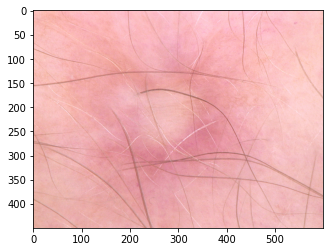

In [19]:
plt.imshow(image)

### visualize one instance of all the nine classes present in the dataset


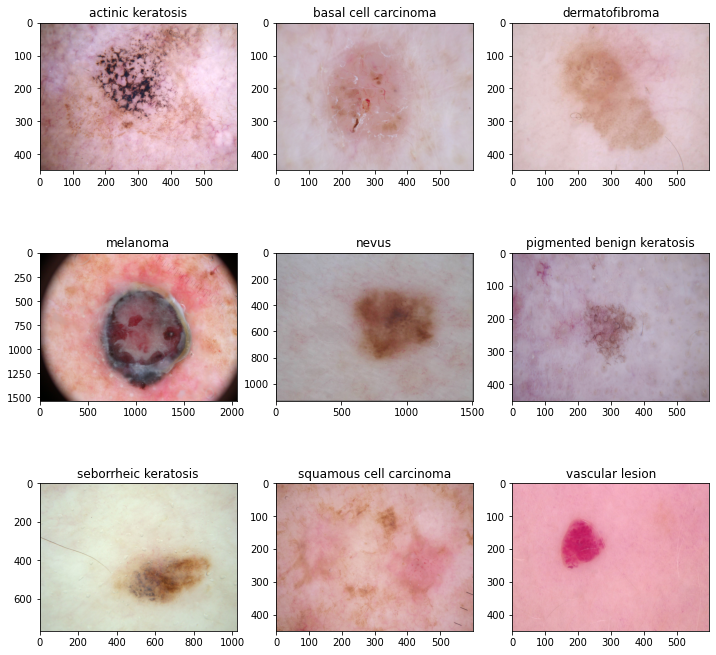

In [20]:
plt.figure(figsize=(12,12))
for i in range(9):
  plt.subplot(3,3,i+1)
  image= plt.imread(str(list(train_dir.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [21]:
import os
import PIL

ValueError: ignored

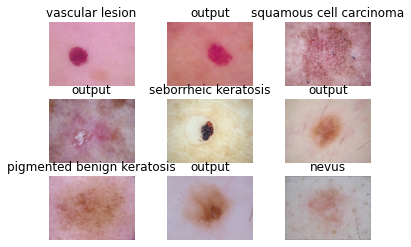

In [23]:
num=0
for dirpath, dirnames, filenames in os.walk(str(train_path)):
    for filename in [f for f in filenames if f.endswith(".jpg")][:1]:
        img = PIL.Image.open(str(dirpath)+"/"+str(filename))
        plt.subplot(3,3,num+1)
        plt.title(str(dirpath).split('/')[-1])
        plt.axis('off')
        plt.imshow(img)
        num=num+1

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [24]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Building

## The Model
- The input to the network is an image of dimensions (180, 180, 3). The first two layers have 32 channels of a 3*3 filter size and the same padding. 
- Then after a max pool layer of stride (2, 2), 
- Then a convolution layer of 32 filter size and filter size (3, 3). This is followed by a max-pooling layer of stride (2, 2) 
- Then a convolution layer of filter size (3, 3) and 64 filters.This is followed by a max-pooling layer of stride (2, 2) 
- Then a convolution layer of filter size (3, 3) and 64 filters.This is followed by a max-pooling layer of stride (2, 2)
- Then We flatten this output. After this there is a fully connected layer. fully connected layer is used to implement softmax function to classify 9 classes. All the hidden layers use ReLU as its activation function. ReLU is more computationally efficient because it results in faster learning and it also decreases the likelihood of vanishing gradient problems.

In [25]:
model=Sequential([
                  tf.keras.layers.experimental.preprocessing.Rescaling(1/255,
                                                                       input_shape=(image_rows,image_cols,3),
                                                                       offset=0.0)])

model.add(Conv2D(filters=32,kernel_size= (3,3),activation='relu',padding='same',input_shape=(image_rows,image_cols,3)))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(9,activation='softmax'))


#### We have dropout of 0.2 introduced to reduce the overfittting

## Compile Model

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                        

We have
- Total params: 1,067,337
Trainable params: 1,067,337

## Training Model

In [28]:
epochs= 20
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    )

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


282/282 [==============================] - 64s 92ms/step - loss: 2.0643 - accuracy: 0.1872 - val_loss: 1.8337 - val_accuracy: 0.3582
Epoch 2/20
282/282 [==============================] - 17s 61ms/step - loss: 1.5970 - accuracy: 0.3860 - val_loss: 1.5143 - val_accuracy: 0.3911
Epoch 3/20
282/282 [==============================] - 17s 61ms/step - loss: 1.3183 - accuracy: 0.4958 - val_loss: 1.2480 - val_accuracy: 0.4996
Epoch 4/20
282/282 [==============================] - 17s 61ms/step - loss: 1.0936 - accuracy: 0.5722 - val_loss: 0.9666 - val_accuracy: 0.6564
Epoch 5/20
282/282 [==============================] - 17s 62ms/step - loss: 0.9606 - accuracy: 0.6412 - val_loss: 0.8489 - val_accuracy: 0.7044
Epoch 6/20
282/282 [==============================] - 17s 62ms/step - loss: 0.7870 - accuracy: 0.6997 - val_loss: 0.7361 - val_accuracy: 0.7387
Epoch 7/20
282/282 [==============================] - 17s 62ms/step - loss: 0.6806 - accuracy: 0.7403 - val_loss: 0.6406 - val_accuracy: 0.7698
Epo

## Visualising Results

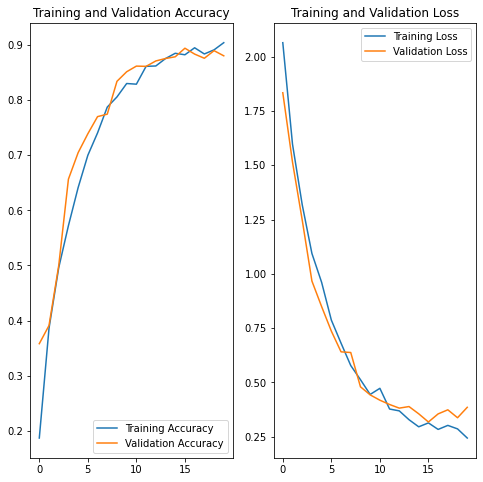

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Key Observations
*   The training 69% and validation 51% accuracy are different 
*   Validation Accuracy is much lesser than Training accuracy.


*   The difference in training and validation accuracy shows the clear case of model being overfit
*   The training accuracy increases with increase in epochs. 
*   The validation accuracy shows is stable and decreases with increase in epochs. 
*  The Validation loss and follows the training loss till 10 epochs approx and then validation loss increases and training loss further decreases with number of epochs





In [30]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [31]:
# images in each classes
for i in range(len(class_names)):
  name= class_names[i]
  number = str(len(list(train_dir.glob(class_names[i]+'/*.jpg'))))
  print(name +":"+ number)


actinic keratosis:121
basal cell carcinoma:377
dermatofibroma:95
melanoma:442
nevus:357
pigmented benign keratosis:462
seborrheic keratosis:77
squamous cell carcinoma:181
vascular lesion:139


In [32]:
# images in each classes
for i in range(len(class_names)):
  name= class_names[i]
  number = str(len(list(test_dir.glob(class_names[i]+'/*.jpg'))))
  print(name +":"+ number)


actinic keratosis:16
basal cell carcinoma:16
dermatofibroma:16
melanoma:16
nevus:16
pigmented benign keratosis:16
seborrheic keratosis:3
squamous cell carcinoma:16
vascular lesion:3


## Problem Identification

Uneven dataset: The training dataset the distribution of image are uneven.



seborrheic keratosis:77
squamous cell carcinoma:181
vascular lesion:139
actinic keratosis:114


The samples in above cases are very less in comparison to 
the other cases. So we need to increase the samples in each case.

**Here we use DATA AUGMENTATION and Augmentor**



# Data Augmentation

In [33]:
data_augmentation = tf.keras.Sequential([
                                          layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
                                          layers.experimental.preprocessing.RandomRotation(0.2)
])

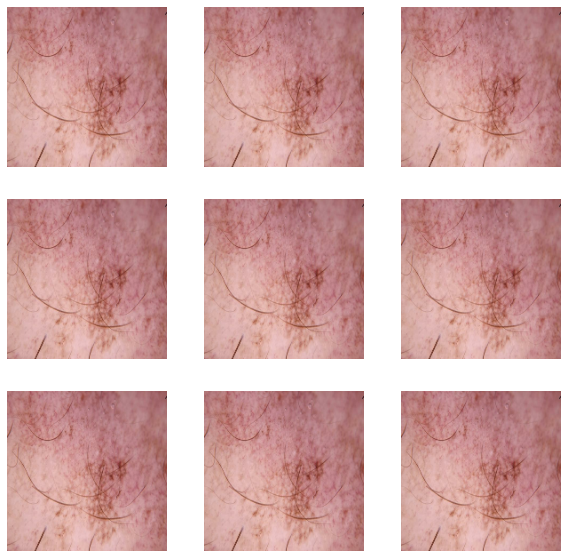

In [34]:
image, label = next(iter(train_ds))
image=np.array(image,np.int32)  
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  augmented_image1=np.array(augmented_image[0],np.int32)  
  plt.imshow((augmented_image1))
  plt.axis("off")

## Model with Data Augumentation

In [35]:
model=Sequential([data_augmentation,
                  tf.keras.layers.experimental.preprocessing.Rescaling(1/255,
                                                                       input_shape=(image_rows,image_cols,3),
                                                                       offset=0.0)])

model.add(Conv2D(filters=32,kernel_size= (3,3),activation='relu',padding='same',input_shape=(image_rows,image_cols,3)))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(9,activation='softmax'))

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
282/282 [==============================] - 26s 84ms/step - loss: 2.1958 - accuracy: 0.1269 - val_loss: 2.1198 - val_accuracy: 0.1289
Epoch 2/20
282/282 [==============================] - 23s 83ms/step - loss: 1.9088 - accuracy: 0.2351 - val_loss: 1.7150 - val_accuracy: 0.3324
Epoch 3/20
282/282 [==============================] - 23s 83ms/step - loss: 1.6029 - accuracy: 0.3747 - val_loss: 1.5214 - val_accuracy: 0.4107
Epoch 4/20
282/282 [==============================] - 23s 83ms/step - loss: 1.4612 - accuracy: 0.4203 - val_loss: 1.4062 - val_accuracy: 0.4378
Epoch 5/20
282/282 [==============================] - 23s 83ms/step - loss: 1.4068 - accuracy: 0.4375 - val_loss: 1.3619 - val_accuracy: 0.4364
Epoch 6/20
282/282 [==============================] - 23s 83ms/step - loss: 1.3313 - accuracy: 0.4669 - val_loss: 1.2708 - val_accuracy: 0.4996
Epoch 7/20
282/282 [==============================] - 23s 83ms/step - loss: 1.2976 - accuracy: 0.4827 - val_loss: 1.2397 - val_accuracy:

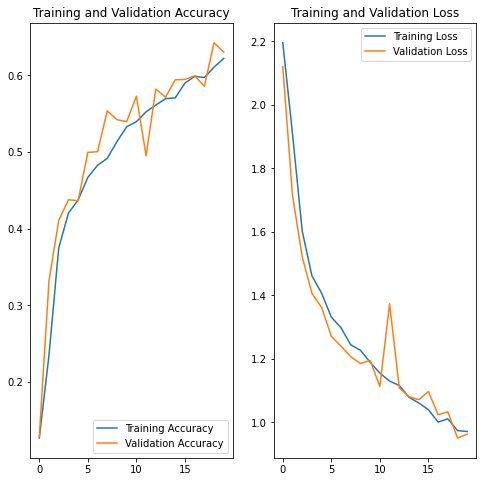

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Key Observations
The training accuracy and validation accuracy are almost equal
They follow similar trends
Although the training accuracy 52%
And validation accuracy 53% has decreased.
The problem of overfitting has been addressed with data augmentation as both accuracies almost follow each other.

But we have the decreased accuracies with needs to be addressed


# Checking for class imbalance

In [39]:
# images in each classes
for i in range(len(class_names)):
  name= class_names[i]
  number = str(len(list(train_dir.glob(class_names[i]+'/*.jpg'))))
  print(name +":"+ number)


actinic keratosis:121
basal cell carcinoma:377
dermatofibroma:95
melanoma:442
nevus:357
pigmented benign keratosis:462
seborrheic keratosis:77
squamous cell carcinoma:181
vascular lesion:139


Uneven dataset: The training dataset the distribution of image are uneven.


- seborrheic keratosis:77
- squamous cell carcinoma:181
- vascular lesion:139
- actinic keratosis:114


The samples in above cases are very less in comparison to 
the other cases. So we need to increase the samples in each case.

## Augmentor for addressing class imbalance problem

In [40]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
import Augmentor

In [42]:
train_path

'/content/gdrive/MyDrive/CNN Assignment/Train'

In [43]:
for i in class_names:
  print(train_path+i)

/content/gdrive/MyDrive/CNN Assignment/Trainactinic keratosis
/content/gdrive/MyDrive/CNN Assignment/Trainbasal cell carcinoma
/content/gdrive/MyDrive/CNN Assignment/Traindermatofibroma
/content/gdrive/MyDrive/CNN Assignment/Trainmelanoma
/content/gdrive/MyDrive/CNN Assignment/Trainnevus
/content/gdrive/MyDrive/CNN Assignment/Trainpigmented benign keratosis
/content/gdrive/MyDrive/CNN Assignment/Trainseborrheic keratosis
/content/gdrive/MyDrive/CNN Assignment/Trainsquamous cell carcinoma
/content/gdrive/MyDrive/CNN Assignment/Trainvascular lesion


In [44]:
path_to_training_dataset=train_path
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + '/'+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 121 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN Assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5866194BB0>: 100%|██████████| 500/500 [00:24<00:00, 20.50 Samples/s]


Initialised with 377 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN Assignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F584E2E5EE0>: 100%|██████████| 500/500 [00:20<00:00, 24.43 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN Assignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F584E3A89D0>: 100%|██████████| 500/500 [00:18<00:00, 26.56 Samples/s]


Initialised with 442 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN Assignment/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F5866181100>: 100%|██████████| 500/500 [01:34<00:00,  5.27 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN Assignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=576x768 at 0x7F5866171490>: 100%|██████████| 500/500 [01:18<00:00,  6.40 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN Assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F584E6985B0>: 100%|██████████| 500/500 [00:18<00:00, 27.09 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN Assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F58661E2A60>: 100%|██████████| 500/500 [00:41<00:00, 12.06 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN Assignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F58CB280AF0>: 100%|██████████| 500/500 [00:18<00:00, 27.64 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN Assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F584E6985B0>: 100%|██████████| 500/500 [00:18<00:00, 26.75 Samples/s]


In [45]:
from glob import glob

In [46]:
path_list = [x for x in glob(os.path.join(train_dir, '*','output', '*.jpg'))]

In [47]:
len(path_list)

13500

In [48]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(train_dir, '*','output', '*.jpg'))]

In [49]:
len(lesion_list_new)

13500

In [50]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))


In [51]:
len(dataframe_dict_new )

13500

In [52]:
class_names[0]

'actinic keratosis'

In [53]:
for i in class_names:
    directory =train_path
    directory_out =train_path+'/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob(i+'/*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 1621 samples.
basal cell carcinoma has 1877 samples.
dermatofibroma has 1595 samples.
melanoma has 1942 samples.
nevus has 1857 samples.
pigmented benign keratosis has 1962 samples.
seborrheic keratosis has 1577 samples.
squamous cell carcinoma has 1681 samples.
vascular lesion has 1639 samples.


## The augmentor has increased the number of samples by 500 in each of the classes. This make the difference in ratio less and between each each class.

# **Model with Augmented Data**

In [54]:
img_height = 180
img_width = 180

In [55]:
data_dir_train=train_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15751 files belonging to 9 classes.
Using 12601 files for training.


In [56]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15751 files belonging to 9 classes.
Using 3150 files for validation.


In [57]:
model=Sequential([
                  tf.keras.layers.experimental.preprocessing.Rescaling(1/255,
                                                                       input_shape=(image_rows,image_cols,3),
                                                                       offset=0.0)])

model.add(Conv2D(filters=32,kernel_size= (3,3),activation='relu',padding='same',input_shape=(image_rows,image_cols,3)))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(9,activation='softmax'))


In [58]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [59]:
history = model.fit(train_ds,
          validation_data= val_ds,
          epochs=25)

Epoch 1/25
394/394 [==============================] - 72s 178ms/step - loss: 2.0219 - accuracy: 0.1997 - val_loss: 1.6949 - val_accuracy: 0.3368
Epoch 2/25
394/394 [==============================] - 66s 166ms/step - loss: 1.4815 - accuracy: 0.4227 - val_loss: 1.2774 - val_accuracy: 0.4952
Epoch 3/25
394/394 [==============================] - 65s 163ms/step - loss: 1.1667 - accuracy: 0.5544 - val_loss: 1.2072 - val_accuracy: 0.5371
Epoch 4/25
394/394 [==============================] - 65s 163ms/step - loss: 0.9704 - accuracy: 0.6300 - val_loss: 0.9239 - val_accuracy: 0.6441
Epoch 5/25
394/394 [==============================] - 67s 167ms/step - loss: 0.7856 - accuracy: 0.7012 - val_loss: 0.6983 - val_accuracy: 0.7337
Epoch 6/25
394/394 [==============================] - 66s 164ms/step - loss: 0.6561 - accuracy: 0.7595 - val_loss: 0.6314 - val_accuracy: 0.7619
Epoch 7/25
394/394 [==============================] - 65s 163ms/step - loss: 0.5479 - accuracy: 0.7955 - val_loss: 0.6307 - val_ac

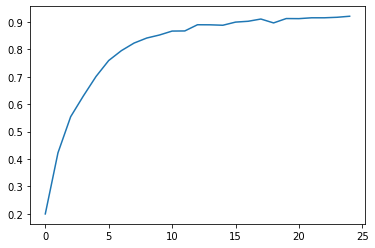

In [60]:
epochs=25
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range =range(epochs)
plt.plot(epochs_range, acc, label='Training Accuracy')

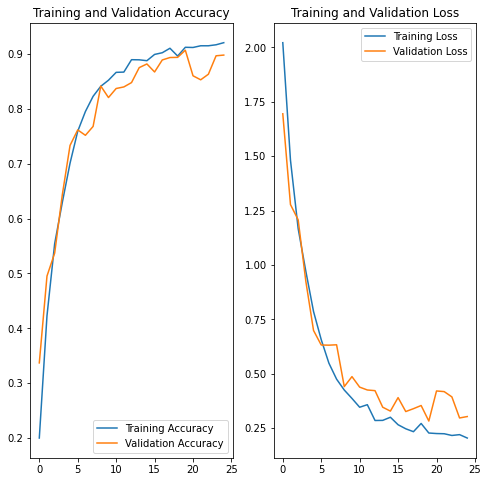

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=25
epochs_range =range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Conclusion
- The accuracy of test set is 90%
- Accuracy of validation dats set is 80%
- Here we went for some extra epochs to try if the model gets improved. But, infact the model tend to increase the overfitting once we for extra epochs.
- The model with the above accuracy shows an increased performace of the model when we get a class balanced training data.
- As we can see from the model performace on the augmented data. 